In [80]:
import soundfile # to read audio file
import numpy as np
import pandas as pd
import librosa # to extract speech features
import glob
import os
import pickle 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [81]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        if (len(X.shape) != 1):
            return [None]
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [82]:
## codes in data
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# only files with these emotion labels are used
emotions_dict ={
    "angry": 0,
    "sad": 1,
    "neutral": 2,
    "happy": 3
}

category_to_emotion = {}

for key in emotions_dict.keys():
    value = emotions_dict[key]
    category_to_emotion[value] = key

In [83]:
def load_data(test_size=0.2, max_amount=10000):
    i = 0
    X, y = [], []
    amount = 0
    for file in glob.glob("ravdess/Audio*/Actor_*/*.wav"):
        if (amount >= max_amount):
            break
        
        basename = os.path.basename(file)
        
        emotion = int2emotion[basename.split("-")[2]]
        allowed_emotions = emotions_dict.keys()
        
        if emotion not in allowed_emotions:
            continue
        emotion_category = emotions_dict[emotion]
        
        features = extract_feature(file, mfcc=True, chroma=True, mel=True)
        
        ## there seems to be some unusable data so lets get rid of those
        if (features[0] == None):
            continue
        
        
            
        X.append(features)
        y.append(emotion_category)
        amount = amount + 1
        
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [84]:
max_amount_of_data = 100
X_train, X_test, y_train, y_test = load_data(test_size=0.25, max_amount=max_amount_of_data)

In [85]:
## make ready for pytorch
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


y_train = np.asarray(y_train)
y_train = y_train.astype(np.float32)
y_test = np.asarray(y_test)
y_test = y_test.astype(np.float32)

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
                                          
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()


In [86]:
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])


[+] Number of training samples: 75
[+] Number of testing samples: 25
[+] Number of features: 180


In [87]:
print("[+] X_train first value's first 5 values", X_train[0][0:5])
print("[+] y_train first value", y_train[0])

[+] X_train first value's first 5 values tensor([-614.5449,   65.8200,  -26.8686,    3.0917,  -10.1031])
[+] y_train first value tensor(1)


In [88]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(DEVICE))

Using cpu device


In [89]:
out = len(emotions_dict.keys())
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=180, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=12)
        self.output = nn.Linear(in_features=12, out_features=out)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [90]:
model = NeuralNetwork().to(DEVICE)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=180, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=12, bias=True)
  (output): Linear(in_features=12, out_features=4, bias=True)
)


In [91]:

BATCH_SIZE = 65
EPOCHS = 10
LR = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [92]:
X_train.shape

torch.Size([75, 180])

In [93]:
epochs = 100
loss_arr = []
epoch_arr = []
model.train()
for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    epoch_arr.append(i)
    
    loss_arr.append(loss.item())
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Text(0.5, 0, 'Epoch number')

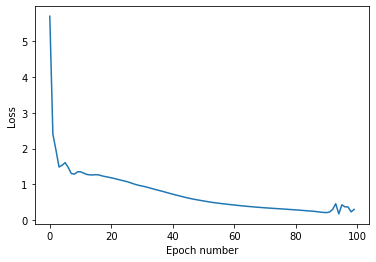

In [94]:

plt.plot(epoch_arr, loss_arr)
plt.ylabel('Loss')
plt.xlabel('Epoch number')

In [95]:
## save model to file
PATH = "model.pt"
torch.save(model, PATH)


In [96]:
# load from file
loaded_model = torch.load(PATH)
loaded_model.eval()

NeuralNetwork(
  (fc1): Linear(in_features=180, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=12, bias=True)
  (output): Linear(in_features=12, out_features=4, bias=True)
)

In [97]:
## make predictions using the loaded model
preds = []
with torch.no_grad():
    for val in X_test:
        y_hat = loaded_model.forward(val)
        preds.append(y_hat.argmax().item())

In [98]:
df = pd.DataFrame({'Y_correct': y_test, 'Y_predicted': preds})
df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y_correct'], df['Y_predicted'])]

In [99]:
df.head()

,Y_correct,Y_predicted,Correct
0,3,3,1
1,0,0,1
2,0,0,1
3,3,3,1
4,0,0,1


In [100]:
for category in category_to_emotion.keys():
    category_results = df[df['Y_correct'] == category]
    res = category_results['Correct'].sum() / len(category_results)
    emotion = category_to_emotion[category]
    to_print = f"Category '{emotion}' accuracy is {res}"
    print(to_print)


Category 'angry' accuracy is 0.8571428571428571
Category 'sad' accuracy is 0.875
Category 'neutral' accuracy is 0.6666666666666666
Category 'happy' accuracy is 0.8571428571428571
